In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
# 設定array的float格式
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
import pandas as pd
pd.set_option('display.max_columns', 100)  #設定可顯示columns的上限
pd.set_option('display.max_rows', 200)  #設定可顯示row的上限
pd.options.display.float_format = '{:,.6f}'.format  #設定浮點數的格式

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

## 讀取套件

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.callbacks import ModelCheckpoint
import h5py

Using TensorFlow backend.


In [3]:
data = pd.read_excel('rawdata/w2_bill_0628.xlsx', encoding='utf8') #帳號每日儲值資料

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1926 entries, 0 to 1925
Columns: 116 entries, account to num_201806023
dtypes: int64(115), object(1)
memory usage: 1.7+ MB


In [5]:
data.head()

,account,num_20180301,num_20180302,num_20180303,num_20180304,num_20180305,num_20180306,num_20180307,num_20180308,num_20180309,num_201803010,num_201803011,num_201803012,num_201803013,num_201803014,num_201803015,num_201803016,num_201803017,num_201803018,num_201803019,num_201803020,num_201803021,num_201803022,num_201803023,num_201803024,num_201803025,num_201803026,num_201803027,num_201803028,num_201803029,num_201803030,num_201803031,num_20180401,num_20180402,num_20180403,num_20180404,num_20180405,num_20180406,num_20180407,num_20180408,num_20180409,num_201804010,num_201804011,num_201804012,num_201804013,num_201804014,num_201804015,num_201804016,num_201804017,num_201804018,...,num_20180505,num_20180506,num_20180507,num_20180508,num_20180509,num_201805010,num_201805011,num_201805012,num_201805013,num_201805014,num_201805015,num_201805016,num_201805017,num_201805018,num_201805019,num_201805020,num_201805021,num_201805022,num_201805023,num_201805024,num_201805025,num_201805026,num_201805027,num_201805028,num_201805029,num_201805030,num_201805031,num_20180601,num_20180602,num_20180603,num_20180604,num_20180605,num_20180606,num_20180607,num_20180608,num_20180609,num_201806010,num_201806011,num_201806012,num_201806013,num_201806014,num_201806015,num_201806016,num_201806017,num_201806018,num_201806019,num_201806020,num_201806021,num_201806022,num_201806023
0,a037880,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,a038661990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,a047989475,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,a0565102,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,a063874,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df = data.iloc[:,-28:-14].copy() #取前14天儲值資料
train_df.head()

,num_201805027,num_201805028,num_201805029,num_201805030,num_201805031,num_20180601,num_20180602,num_20180603,num_20180604,num_20180605,num_20180606,num_20180607,num_20180608,num_20180609
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
train_y = data.iloc[:, -14:-7].copy()
train_y.head()

,num_201806010,num_201806011,num_201806012,num_201806013,num_201806014,num_201806015,num_201806016
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [8]:
test_df = data.iloc[:,-21:-7].copy()
test_df.head()

,num_20180603,num_20180604,num_20180605,num_20180606,num_20180607,num_20180608,num_20180609,num_201806010,num_201806011,num_201806012,num_201806013,num_201806014,num_201806015,num_201806016
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
test_y = data.iloc[:, -7:].copy()
test_y.head()

,num_201806017,num_201806018,num_201806019,num_201806020,num_201806021,num_201806022,num_201806023
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [10]:
train_value = train_df.values
train_value = np.reshape(train_value, (train_value.shape[0], train_value.shape[1], 1))
print(train_value.shape) #樣本數, timesteps, 特徵數

(1926, 14, 1)


In [11]:
test_value = test_df.values
test_value = np.reshape(test_value, (test_value.shape[0], test_value.shape[1], 1))
print(test_value.shape) #樣本數, timesteps, 特徵數

(1926, 14, 1)


## 參數調整

In [12]:
def get_model(node=128, dropout_rate=0.3, opt='nadam'):
    model = Sequential()
    model.add(GRU(units=node,input_shape=(train_value.shape[1], train_value.shape[2]), return_sequences=True))#timestep, feature
    model.add(Dropout(dropout_rate)) #依一定比例斷開神經元連結，降低模型複雜度，避免過擬合
    model.add(GRU(units=node))
    model.add(Dropout(dropout_rate))
    model.add(Dense(7, activation='sigmoid')) #模型輸出未來7天的儲值機率
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model #回傳keras模型

In [13]:
from keras.wrappers.scikit_learn import KerasClassifier
neural_network = KerasClassifier(build_fn=get_model, batch_size=8,epochs=50,verbose=0)

In [14]:
#nodes = [64, 128, 256]
#dropout_rates = [0.3,0.4]
#opts = ['nadam', 'adam']

#hyperparameters = dict(node=nodes, dropout_rate=dropout_rates, opt=opts) #必須為字典格式

In [15]:
#grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)

In [16]:
#grid_result = grid.fit(train_value, train_y, verbose=2) #verbose設定為1可以看到詳細訓練過程

In [17]:
#print('Best: %f using %s' %(grid_result.best_score_, grid_result.best_params_))

In [18]:
#model = get_model(**grid_result.best_params_)

## 利用ModelCheckpoint

In [39]:
#filepath為存放hdf5檔的路徑。
filepath="weights.best.hdf5"

#monitor代表modelcheckpoint監控的參數。
#save_best_only代表modelcheckpoint是否只儲存最佳化的參數，若設定為否，則每個epoch訓練出的參數都會儲存。
#mode可選擇 min、max，在下列代碼中設定為min，代表只要loss最小時的參數。
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=2, save_best_only=True, mode='min')

#由於fit的callbacks要求list格式，所以轉換成list格式。
callbacks_list = [checkpoint] 

In [20]:
%%time
model = get_model()

md = model.fit(train_value, train_y , epochs=300,batch_size=16, verbose=1,callbacks=callbacks_list)

Epoch 1/300
1926/1926 [==============================] - 3s 2ms/step - loss: 0.2182 - acc: 0.9507

Epoch 00001: loss improved from inf to 0.21822, saving model to weights.best.hdf5
Epoch 2/300
1926/1926 [==============================] - 2s 999us/step - loss: 0.1870 - acc: 0.9524

Epoch 00002: loss improved from 0.21822 to 0.18701, saving model to weights.best.hdf5
Epoch 3/300
1926/1926 [==============================] - 2s 980us/step - loss: 0.1841 - acc: 0.9523

Epoch 00003: loss improved from 0.18701 to 0.18415, saving model to weights.best.hdf5
Epoch 4/300
1926/1926 [==============================] - 2s 996us/step - loss: 0.1834 - acc: 0.9518

Epoch 00004: loss improved from 0.18415 to 0.18342, saving model to weights.best.hdf5
Epoch 5/300
1926/1926 [==============================] - 2s 994us/step - loss: 0.1837 - acc: 0.9522

Epoch 00005: loss did not improve from 0.18342
Epoch 6/300
1926/1926 [==============================] - 2s 1ms/step - loss: 0.1820 - acc: 0.9522

Epoch 00006


Epoch 00048: loss improved from 0.16326 to 0.16166, saving model to weights.best.hdf5
Epoch 49/300
1926/1926 [==============================] - 2s 964us/step - loss: 0.1640 - acc: 0.9576

Epoch 00049: loss did not improve from 0.16166
Epoch 50/300
1926/1926 [==============================] - 2s 967us/step - loss: 0.1612 - acc: 0.9571

Epoch 00050: loss improved from 0.16166 to 0.16117, saving model to weights.best.hdf5
Epoch 51/300
1926/1926 [==============================] - 2s 963us/step - loss: 0.1615 - acc: 0.9574

Epoch 00051: loss did not improve from 0.16117
Epoch 52/300
1926/1926 [==============================] - 2s 965us/step - loss: 0.1598 - acc: 0.9582

Epoch 00052: loss improved from 0.16117 to 0.15981, saving model to weights.best.hdf5
Epoch 53/300
1926/1926 [==============================] - 2s 973us/step - loss: 0.1582 - acc: 0.9588

Epoch 00053: loss improved from 0.15981 to 0.15819, saving model to weights.best.hdf5
Epoch 54/300
1926/1926 [===========================

Epoch 99/300
1926/1926 [==============================] - 2s 956us/step - loss: 0.1452 - acc: 0.9622

Epoch 00099: loss improved from 0.14571 to 0.14519, saving model to weights.best.hdf5
Epoch 100/300
1926/1926 [==============================] - 2s 946us/step - loss: 0.1453 - acc: 0.9624

Epoch 00100: loss did not improve from 0.14519
Epoch 101/300
1926/1926 [==============================] - 2s 966us/step - loss: 0.1451 - acc: 0.9624

Epoch 00101: loss improved from 0.14519 to 0.14507, saving model to weights.best.hdf5
Epoch 102/300
1926/1926 [==============================] - 2s 1ms/step - loss: 0.1464 - acc: 0.9622

Epoch 00102: loss did not improve from 0.14507
Epoch 103/300
1926/1926 [==============================] - 2s 986us/step - loss: 0.1459 - acc: 0.9621

Epoch 00103: loss did not improve from 0.14507
Epoch 104/300
1926/1926 [==============================] - 2s 908us/step - loss: 0.1456 - acc: 0.9625

Epoch 00104: loss did not improve from 0.14507
Epoch 105/300
1926/1926 [

1926/1926 [==============================] - 2s 1ms/step - loss: 0.1465 - acc: 0.9621

Epoch 00152: loss did not improve from 0.14135
Epoch 153/300
1926/1926 [==============================] - 2s 962us/step - loss: 0.1430 - acc: 0.9627

Epoch 00153: loss did not improve from 0.14135
Epoch 154/300
1926/1926 [==============================] - 2s 950us/step - loss: 0.1432 - acc: 0.9633

Epoch 00154: loss did not improve from 0.14135
Epoch 155/300
1926/1926 [==============================] - 2s 942us/step - loss: 0.1434 - acc: 0.9625

Epoch 00155: loss did not improve from 0.14135
Epoch 156/300
1926/1926 [==============================] - 2s 951us/step - loss: 0.1428 - acc: 0.9632

Epoch 00156: loss did not improve from 0.14135
Epoch 157/300
1926/1926 [==============================] - 2s 942us/step - loss: 0.1440 - acc: 0.9631

Epoch 00157: loss did not improve from 0.14135
Epoch 158/300
1926/1926 [==============================] - 2s 981us/step - loss: 0.1449 - acc: 0.9628

Epoch 00158: 

1926/1926 [==============================] - 2s 944us/step - loss: 0.1426 - acc: 0.9629

Epoch 00260: loss did not improve from 0.14047
Epoch 261/300
1926/1926 [==============================] - 2s 955us/step - loss: 0.1412 - acc: 0.9635

Epoch 00261: loss did not improve from 0.14047
Epoch 262/300
1926/1926 [==============================] - 2s 969us/step - loss: 0.1414 - acc: 0.9632

Epoch 00262: loss did not improve from 0.14047
Epoch 263/300
1926/1926 [==============================] - 2s 949us/step - loss: 0.1411 - acc: 0.9634

Epoch 00263: loss did not improve from 0.14047
Epoch 264/300
1926/1926 [==============================] - 2s 961us/step - loss: 0.1438 - acc: 0.9617

Epoch 00264: loss did not improve from 0.14047
Epoch 265/300
1926/1926 [==============================] - 2s 964us/step - loss: 0.1492 - acc: 0.9610

Epoch 00265: loss did not improve from 0.14047
Epoch 266/300
1926/1926 [==============================] - 2s 951us/step - loss: 0.1458 - acc: 0.9617

Epoch 00266

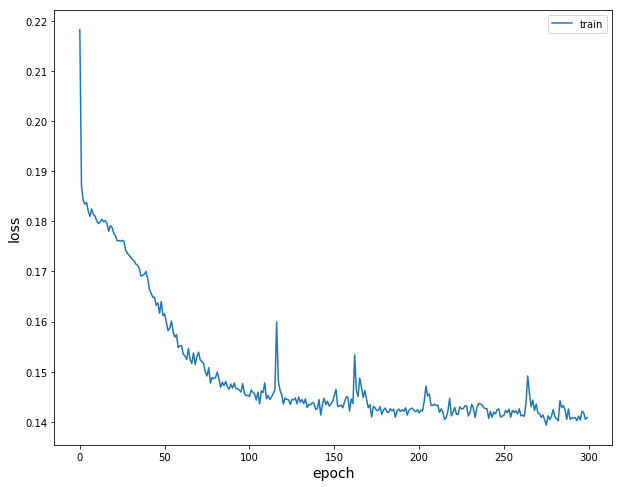

In [21]:
#繪製loss的走勢圖
plt.figure(figsize=(10,8))
plt.plot(md.history['loss'])
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train'], loc='best')

In [22]:
model.load_weights(filepath=filepath) #模型讀取剛剛紀錄的最佳參數
train_y_pred_lstm = model.predict(train_value)

In [25]:
pred_df = pd.DataFrame(train_y_pred_lstm) #train_y_pred_lstm為np.array將其轉換成pandas的dataframe

for i in range(7):
    pred_df[i] = np.round(pred_df[i])

pred_df['sum'] = pred_df.sum(axis=1)
pred_df.head()

,0,1,2,3,4,5,6,sum
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
result = train_y.copy()
result['遊戲帳號'] = data.account
result['實際儲值天數'] = result.sum(axis=1)

result['預測儲值天數']  = pred_df['sum']
result = result[['遊戲帳號','實際儲值天數', '預測儲值天數']]
result.head()

,遊戲帳號,實際儲值天數,預測儲值天數
0,a037880,0,0.000000
1,a038661990,0,0.000000
2,a047989475,0,0.000000
3,a0565102,0,0.000000
4,a063874,0,0.000000


In [27]:
y_true = result.實際儲值天數
y_pred = result.預測儲值天數

In [28]:
score = accuracy_score(y_true, y_pred)
score

0.7969885773624091

In [29]:
model.load_weights(filepath=filepath) #模型讀取modelcheckpoint記錄下的最佳參數
test_y_pred_lstm = model.predict(test_value)

In [30]:
test_pred_df = pd.DataFrame(test_y_pred_lstm) #test_y_pred_lstm為np.array將其轉換成pandas的dataframe

#將每天儲值機率四捨五入，來判斷該天是否儲值
for i in range(7):
    test_pred_df[i] = np.round(test_pred_df[i])

test_pred_df['sum'] = test_pred_df.sum(axis=1)
test_pred_df.head()

,0,1,2,3,4,5,6,sum
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
result = test_y.copy()
result['遊戲帳號'] = data.account
result['實際儲值天數'] = result.sum(axis=1)

result['預測儲值天數']  = test_pred_df['sum']
result = result[['遊戲帳號','實際儲值天數', '預測儲值天數']]

In [32]:
result.head(1)

,遊戲帳號,實際儲值天數,預測儲值天數
0,a037880,0,0.000000


In [42]:
result[result['遊戲帳號'] == 'a0903326']

,遊戲帳號,實際儲值天數,預測儲值天數
8,a0903326,5,0.000000


In [36]:
y_true = result.實際儲值天數
y_pred = result.預測儲值天數

In [37]:
#用準確率衡量模型在測試樣本上的表現
score = accuracy_score(y_true, y_pred)
score

0.7637590861889927